[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/multiple-schemas.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239434-lesson-3-multiple-schemas)

# Multiple Schemas

## 復習

state-reducers.ipynb では、ステートスキーマ(state schema)とリデューサ(reducer)について説明しました。

通常、すべてのグラフノードは単一のスキーマで通信します。

また、この単一のスキーマはグラフの入力と出力のキー/チャンネルを含みます。

## 目標

しかし、上記にもう少し制御したい場合もあります：

* 内部ノードは、グラフの入力/出力に *必要でない* 情報を渡すかもしれません。

* また、グラフの入出力スキーマを使い分けたい場合もあります。例えば、出力は関連する1つの出力キーのみを含むかもしれません。

複数のスキーマ(mutilple schemas)を持つグラフをカスタマイズする方法をいくつか説明します。


In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph

## Private State

まず、ノード間で[private state](https://langchain-ai.github.io/langgraph/how-tos/pass_private_state/)を渡す場合について説明します。

これはグラフの中間的な作業ロジックの一部としての利用には便利です。private state はグラフ全体の入出力には関係ないためです。

ここでは `OverallState` と `PrivateState` を定義します。

`node_2`は入力として `PrivateState` を使用しますが、出力は `OverallState` に書き出します。


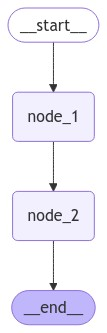

In [1]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END


class OverallState(TypedDict):
    foo: int


class PrivateState(TypedDict):
    baz: int


def node_1(state: OverallState) -> PrivateState:
    print("---Node 1---")
    return {"baz": state["foo"] + 1}


def node_2(state: PrivateState) -> OverallState:
    print("---Node 2---")
    return {"foo": state["baz"] + 1}


# Build graph
builder = StateGraph(OverallState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [3]:
# node_1で+1, node_2で+1される
graph.invoke({"foo": 1})

---Node 1---
---Node 2---


{'foo': 3}

`baz` は `PrivateState` にのみ含まれます。

`node_2`は入力として `PrivateState` を使用しますが、出力は `OverallState` に書き出します。

つまり、`baz` は `OverallState` に含まれないので、グラフの出力から除外されていることがわかります。


## Input / Output Schema

デフォルトでは `StateGraph` は単一のスキーマを取り込み、全てのノードはそのスキーマで通信することが期待されます。

しかし、[グラフの入出力スキーマを明示的に定義する](https://langchain-ai.github.io/langgraph/how-tos/input_output_schema/?h=input+outp)ことも可能です。

多くの場合、このようなケースでは、グラフ操作に関連する*すべての*キーを含む「内部」スキーマを定義します。

しかし、入力と出力を制約するために特定の `input` と `output` スキーマを使います。

まず、単一のスキーマでグラフを実行してみましょう。


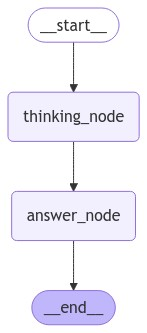

In [5]:
class OverallState(TypedDict):
    question: str
    answer: str
    notes: str


def thinking_node(state: OverallState) -> dict[str, str]:
    return {"answer": "bye", "notes": "... his is name is Lance"}


def answer_node(state: OverallState) -> dict[str, str]:
    return {"answer": "bye Lance"}


graph = StateGraph(OverallState)
graph.add_node("thinking_node", thinking_node)
graph.add_node("answer_node", answer_node)
graph.add_edge(START, "thinking_node")
graph.add_edge("thinking_node", "answer_node")
graph.add_edge("answer_node", END)

graph = graph.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

invoke() の出力には `OverallState` のすべてのキーが含まれていることに注意してください。

In [9]:
graph.invoke({"question": "hi"})
# answer のvalueは、thinking_node の値を入れた後に、answer_node の値で上書きされている

{'question': 'hi', 'answer': 'bye Lance', 'notes': '... his is name is Lance'}


では、特定の `input` と `output` スキーマをグラフで使ってみましょう。

ここで、 `input` / `output` スキーマは、グラフの入力と出力で許可されるキーに対して *フィルタリング* を行います。

さらに、型ヒント(type hint) `state： InputState` を使って各ノードの入力スキーマを指定することができます。

これはグラフが複数のスキーマを使用している場合に重要です。

例えば、`answer_node` の出力が `OutputState` にフィルタリングされることを示すために、以下の型ヒント(type hint)を使用します。




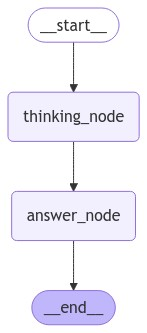

{'answer': 'bye Lance'}

In [11]:
class InputState(TypedDict):
    question: str


class OutputState(TypedDict):
    answer: str


class OverallState(TypedDict):
    question: str
    answer: str
    notes: str


def thinking_node(state: InputState) -> dict[str, str]:
    return {"answer": "bye", "notes": "... his is name is Lance"}


def answer_node(state: OverallState) -> OutputState:
    return {"answer": "bye Lance"}


graph = StateGraph(OverallState, input=InputState, output=OutputState)
graph.add_node("thinking_node", thinking_node)
graph.add_node("answer_node", answer_node)
graph.add_edge(START, "thinking_node")
graph.add_edge("thinking_node", "answer_node")
graph.add_edge("answer_node", END)

graph = graph.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

# 誰が何と話しかけても、 {'answer': 'bye Lance'} と返す
graph.invoke({"question": "hi"})

`output`スキーマは `answer`キーのみに出力を制約していることがわかります。
